In [10]:
from functools import partial
import os
import torch
from guided_diffusion.unet import create_model
from guided_diffusion.gaussian_diffusion import create_sampler
from util.logger import get_logger
import numpy as np
from skimage.io import imsave
import warnings
warnings.filterwarnings('ignore')
from util.utils import image_read,load_yaml,norm_img,tensor_to_numpy
from guided_diffusion.unet import create_model,create_model_ir
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')


In [5]:
model_config = load_yaml('configs/vi_model_config_imagenet.yaml')  
ir_model_config = load_yaml('configs/ir_model_config_imagenet.yaml') 
diffusion_config = load_yaml('configs/diffusion_config.yaml')

logger = get_logger()
device = "cuda:1"
input_path="./input"     
out_path = f'./output2/{diffusion_config["sampler"]}'

# Working directory
os.makedirs(out_path, exist_ok=True)
os.makedirs(os.path.join(out_path, 'recon'), exist_ok=True)
os.makedirs(os.path.join(out_path, 'progress'), exist_ok=True)

img_name = "FLIR_08248.jpg"

# logger
logger = get_logger()

# Device setting
# device_str = f"cuda:{args.gpu}" if torch.cuda.is_available() else 'cpu'
# logger.info(f"Device set to {device_str}.")
# device = torch.device(device_str)  
device = "cuda:1"


# Load model
model = create_model(**model_config)
model = model.to(device)
model.eval()


# Load diffusion sampler
sampler = create_sampler(**diffusion_config) 
sample_fn = partial(sampler.p_sample_loop, model=model)

# Working directory
test_folder=r"input"     
os.makedirs(out_path, exist_ok=True)
for img_dir in ['recon', 'progress']:
    os.makedirs(os.path.join(out_path, img_dir), exist_ok=True)
def norm_img(sample):
    sample=(sample-np.min(sample))/(np.max(sample)-np.min(sample))
    sample=((sample)*255).astype(np.uint8)
    return sample
i=0
inf_img = image_read(os.path.join(test_folder,"ir",img_name),mode='GRAY')[np.newaxis,np.newaxis, ...]/255.0 
vis_img = image_read(os.path.join(test_folder,"vi",img_name), mode='GRAY')[np.newaxis,np.newaxis, ...]/255.0 

inf_img = inf_img*2-1
vis_img = vis_img*2-1

# crop to make divisible
scale = 32
h, w = inf_img.shape[2:]
h = h - h % scale
w = w - w % scale

inf_img = ((torch.FloatTensor(inf_img))[:,:,:h,:w]).to(device)
vis_img = ((torch.FloatTensor(vis_img))[:,:,:h,:w]).to(device)
assert inf_img.shape == vis_img.shape

logger.info(f"Inference for image {i}")

# Sampling
seed = 3407
torch.manual_seed(seed)
x_start = torch.randn((inf_img.repeat(1, 3, 1, 1)).shape, device=device)  
print(inf_img.shape) # torch.Size([1, 1, 288, 512])



2024-08-05 02:30:47,291 [DPS] >> Inference for image 0
2024-08-05 02:30:47,291 [DPS] >> Inference for image 0
2024-08-05 02:30:47,291 [DPS] >> Inference for image 0
2024-08-05 02:30:47,291 [DPS] >> Inference for image 0


sampler = ddim
torch.Size([1, 1, 288, 480])


In [8]:
print(inf_img.shape)
with torch.no_grad():
    sample = sample_fn(x_start=x_start,ir_model = None, record=False, I = inf_img, V = vis_img, save_root=out_path, img_index = os.path.splitext(img_name)[0], lamb=0.5,rho=0.001)
    # Convert the tensor to a NumPy array and adjust dimensions


torch.Size([1, 1, 288, 480])


  0%|          | 0/100 [00:00<?, ?it/s]

In [14]:
print(sample.shape)

torch.Size([1, 3, 288, 480])


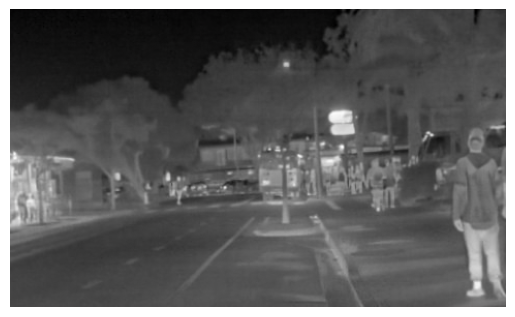

In [16]:

# 将 [1, 3, 288, 480] 转换为 [3, 288, 480]
rgb_img = sample.squeeze(0).cpu().numpy()  # 移除批次维度

# 将 [3, 288, 480] 转换为 [288, 480, 3]
rgb_img = np.transpose(rgb_img, (1, 2, 0))

# 归一化到 [0, 1] 范围
rgb_img = (rgb_img - np.min(rgb_img)) / (np.max(rgb_img) - np.min(rgb_img))

# 显示图像
plt.imshow(rgb_img)
plt.axis('off')  # 关闭坐标轴
plt.show()
